# Network Structure Analysis - Section 4.1.2
## German Federal Election 2021 - Twitter Discourse Analysis

This notebook explores the network structure statistics for political Twitter discourse during the 2021 German Federal Election period. We analyze both network-level and node-level metrics to understand discourse fragmentation patterns.

In [109]:
# Enable inline plotting
%matplotlib inline





In [110]:
import os
from datetime import datetime, timedelta


os.environ[
    'GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/zetta/projects/twitter-analysis-python/.secrets/service-account.json'

creds_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
print(f"Current credentials path: {creds_path}")

# Define global output directory
OUTPUT_DIR = "outputs"  # Modify this if needed

# Ensure the directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Figure size
PLOT_FIGURE_SIZE = (12, 12 / 16 * 9)
PLOT_FIGURE_SIZE_SQUARE = (12, 12)
PLOT_DPI = 300

# Font sizes
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = BASE_FONT_SIZE + 2
DEFAULT_FONT_SIZE = BASE_FONT_SIZE
AXIS_FONT_SIZE = BASE_FONT_SIZE
LEGEND_FONT_SIZE = BASE_FONT_SIZE

XTICK_LABEL_SIZE = BASE_FONT_SIZE
YTICK_LABEL_SIZE = BASE_FONT_SIZE

# Font weights
FONT_TITLE_WEIGHT = 'regular'
FONT_WEIGHT = 'regular'
FONT_FAMILY = 'sans-serif'
FONT_NAMES = ['Arial']

# Padding
TITLE_PAD = 15

ELECTION_DATE = datetime(2021, 9, 26)
ELECTION_DATE_LABEL = 'Election Day (Sep 26, 2021)'

# Line width
LINE_WIDTH = 3
MARKER_SIZE = 10

# Legend
LEGEND_POSITION = 'upper left'
LEGEND_FRAME_ALPHA = 0.9
LEGEND_FONT_SIZE = 12
LEGEND_EDGE_COLOR = 'lightgray'

# Grid
GRID_COLOR = '#E0E0E0'
GRID_ALPHA = 0.5

COLOR_PARTY = {
    "cdu": "#32302e",
    "CDU": "#32302e",
    "spdde": "#e3000f",
    "SPD": "#e3000f",
    "csu": "#00568d",
    "CSU": "#00568d",
    "fdp": "#ffed00",
    "FDP": "#ffed00",
    "die_gruenen": "#46962b",
    "Bündnis 90/Die Grünen": "#46962b",
    "afd": "#009ee0",
    "AfD": "#009ee0",
    "dielinke": "#562883",
    "DIE LINKE": "#562883",
    "NA": "#a4a4a4"
}

# Map party IDs to proper names
PARTY_NAMES = {
    "cdu": "CDU",
    "spdde": "SPD",
    "csu": "CSU",
    "fdp": "FDP",
    "die_gruenen": "Die Grünen",
    "Bündnis 90/Die Grünen": "Die Grünen",
    "dielinke": "Die Linke",
    "DIE LINKE": "Die Linke",
    "afd": "AfD",
    "NA": "Other"
}

QUERY_USE_CACHE = True

# Define pastel colors for metrics
METRIC_COLORS = {
    'modularity': '#4C72B0',           # Muted Blue
    'assortativity': '#E69F00',        # Darker Orange (replacing yellow for better visibility)
    'network_avg_toxicity': '#C44E52', # Muted Red
    'rich_club_coefficient': '#55A868', # Muted Green
    'average_clustering': '#8172B2',   # Muted Purple
    'transitivity': '#009E73',         # Teal
    'density': '#D55E00'               # Bright Orange
}

Current credentials path: /Users/zetta/projects/twitter-analysis-python/.secrets/service-account.json


## 1. Setup and Configuration

Import libraries and set up BigQuery connections.

In [111]:
# Data handling and analysis
import pandas as pd
import numpy as np
from enum import Enum, auto

# BigQuery
from google.cloud import bigquery
from google.cloud.exceptions import GoogleCloudError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

# Define colors
colors = [
    '#4A4A4A',  # Dark Gray - Good for "Overall" or neutral data
    '#4C72B0',  # Muted Blue - Calm, reliable
    '#C44E52',  # Muted Red - Strong, noticeable
    '#55A868',  # Muted Green - Natural, balanced
    '#8172B2',  # Muted Purple - Soft but distinct
    '#E69F00',  # Darker Orange - More visible than yellow
    '#009E73',  # Teal - Good contrast with other colors
    '#D55E00',  # Bright Orange - High visibility
    '#0072B2',  # Darker Blue - Good for emphasis
    '#CC79A7'   # Pink - Provides good contrast
]
sns.set_palette(sns.color_palette(colors))

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = PLOT_FIGURE_SIZE
plt.rcParams['font.family'] = FONT_FAMILY
plt.rcParams['axes.labelcolor'] = "#6A6A6A"
plt.rcParams['axes.labelweight'] = "light"
plt.rcParams['font.size'] = BASE_FONT_SIZE
plt.rcParams['figure.titleweight'] = "medium"
plt.rcParams['xtick.labelsize'] = XTICK_LABEL_SIZE
plt.rcParams['ytick.labelsize'] = YTICK_LABEL_SIZE
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['axes.labelpad'] = 10

# Grid
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = "#D3D3D3"

# Legend
plt.rcParams['legend.framealpha'] = LEGEND_FRAME_ALPHA
plt.rcParams['legend.edgecolor'] = LEGEND_EDGE_COLOR
plt.rcParams['legend.fontsize'] = LEGEND_FONT_SIZE

In [112]:
# BigQuery configuration
project_id = "grounded-nebula-408412"
dataset_source = "twitter_analysis_00_source_python"
dataset_network = "twitter_analysis_30_network_analysis"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

In [113]:
# Account type enumeration
class AccountTypeEnum(str, Enum):
    """Enumeration of all Account Types"""
    MEDIA_NEWS = "Media/News"
    POLITICIAN = "Politician"
    POLITICAL_PARTY = "Political Party"
    INSTITUTION = "Institution"
    BUSINESS = "Business"
    ACTIVIST_GROUP = "Activist Group"
    OTHER = "Other"

# Define colors for account types
ACCOUNT_TYPE_COLORS = {
    AccountTypeEnum.MEDIA_NEWS: '#4C72B0',        # Blue
    AccountTypeEnum.POLITICIAN: '#C44E52',        # Red
    AccountTypeEnum.POLITICAL_PARTY: '#55A868',   # Green
    AccountTypeEnum.INSTITUTION: '#8172B2',       # Purple
    AccountTypeEnum.BUSINESS: '#CCB974',          # Yellow
    AccountTypeEnum.ACTIVIST_GROUP: '#64B5CD',    # Light Blue
    AccountTypeEnum.OTHER: '#999999'              # Gray
}

In [114]:
# Utility functions for plot formatting (reusing from the foundational notebook)
def format_plot(ax,
                title=None,
                xlabel=None,
                ylabel=None,
                ylim_start=0,
                ylim_end=None,
                legend_loc=None,
                grid=True):
    """Apply standard formatting to a matplotlib axis."""
    if title:
        ax.set_title(title, fontweight=FONT_TITLE_WEIGHT, pad=TITLE_PAD, fontsize=TITLE_FONT_SIZE)

    if xlabel:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)

    if ylabel:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)

    # Set y-axis limits
    if ylim_end is not None:
        ax.set_ylim(ylim_start, ylim_end)
    elif ylim_start > 0:
        # Only set bottom limit
        ax.set_ylim(bottom=ylim_start)

    # Grid
    if grid:
        ax.grid(True, linestyle="--", alpha=GRID_ALPHA, color=GRID_COLOR)
        ax.set_axisbelow(True)  # Put grid behind data points

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend if requested
    if legend_loc:
        ax.legend(loc=legend_loc,
                  frameon=True,
                  framealpha=LEGEND_FRAME_ALPHA,
                  edgecolor=LEGEND_EDGE_COLOR,
                  fontsize=LEGEND_FONT_SIZE)

    return ax

def add_election_line(ax, label=True):
    """Add a vertical line for the election date."""
    line = ax.axvline(
        ELECTION_DATE,
        color='red',
        linestyle='--',
        linewidth=LINE_WIDTH,
        label=ELECTION_DATE_LABEL if label else None
    )
    return line

In [115]:
def run_query(query, use_cache=True):
    """Execute a BigQuery query and return results as a DataFrame."""
    try:
        # Configure the query job to use cache if requested
        job_config = bigquery.QueryJobConfig(use_query_cache=use_cache)

        # Execute the query
        query_job = client.query(query, job_config=job_config)

        # Convert to DataFrame without using the BigQuery Storage API
        results_df = query_job.to_dataframe(create_bqstorage_client=False)

        # Print information about the results
        print(f"Query executed successfully. Retrieved {len(results_df)} rows.")
        if len(results_df) > 0:
            print(f"Columns: {list(results_df.columns)}")
        else:
            print("Warning: Query returned no results.")

        return results_df

    except Exception as e:
        print(f"Error executing query: {str(e)}")
        # Return an empty DataFrame so code can continue without errors
        return pd.DataFrame()

## 2. Network-Level Metrics Analysis

In this section, we analyze network-level metrics to understand the overall structure of political discourse on Twitter. We'll examine how these metrics change over time and identify key patterns during the election period.

In [116]:
# Query to retrieve network metrics for the all-discourse network
network_metrics_query = """
SELECT 
    month_start,
    table_name,
    nodes,
    edges,
    density,
    connected_components,
    transitivity,
    modularity,
    modularity_classes,
    assortativity,
    network_avg_toxicity,
    median_node_toxicity,
    max_core_number,
    avg_core_number,
    rich_club_coefficient,
    average_clustering
FROM 
    `grounded-nebula-408412.twitter_analysis_00_source_python.network_metrics_all`
ORDER BY
    month_start
"""

# Execute the query
network_metrics_df = run_query(network_metrics_query, use_cache=QUERY_USE_CACHE)

# Check if data is available
if network_metrics_df.empty:
    print("No data returned from the network metrics query.")
else:
    # Convert month_start to datetime
    network_metrics_df['month_start'] = pd.to_datetime(network_metrics_df['month_start'])
    
    # Display the first few rows
    network_metrics_df.head()

Query executed successfully. Retrieved 24 rows.
Columns: ['month_start', 'table_name', 'nodes', 'edges', 'density', 'connected_components', 'transitivity', 'modularity', 'modularity_classes', 'assortativity', 'network_avg_toxicity', 'median_node_toxicity', 'max_core_number', 'avg_core_number', 'rich_club_coefficient', 'average_clustering']


### 2.1 Temporal Heatmap of Network Metrics

Let's create a heatmap showing how different network metrics change over time.

In [117]:
# Select metrics of interest
metrics_of_interest = [
    'modularity', 
    'assortativity', 
    'network_avg_toxicity', 
    'rich_club_coefficient', 
    'average_clustering',
    'transitivity',
    'density'
]

# Prepare data for the heatmap
def prepare_heatmap_data(df, metrics):
    """Prepare data for the network metrics heatmap."""
    # Create a copy with only the relevant columns
    heatmap_df = df[['month_start'] + metrics].copy()
    
    # Set month_start as index
    heatmap_df.set_index('month_start', inplace=True)
    
    # Ensure timestamps are formatted properly for display
    heatmap_df.index = heatmap_df.index.strftime('%Y-%m')
    
    return heatmap_df

# Create heatmap data
heatmap_data = prepare_heatmap_data(network_metrics_df, metrics_of_interest)

### 2.2 Individual Metric Trends

Let's create individual line charts for each network metric to clearly visualize their trends over time.

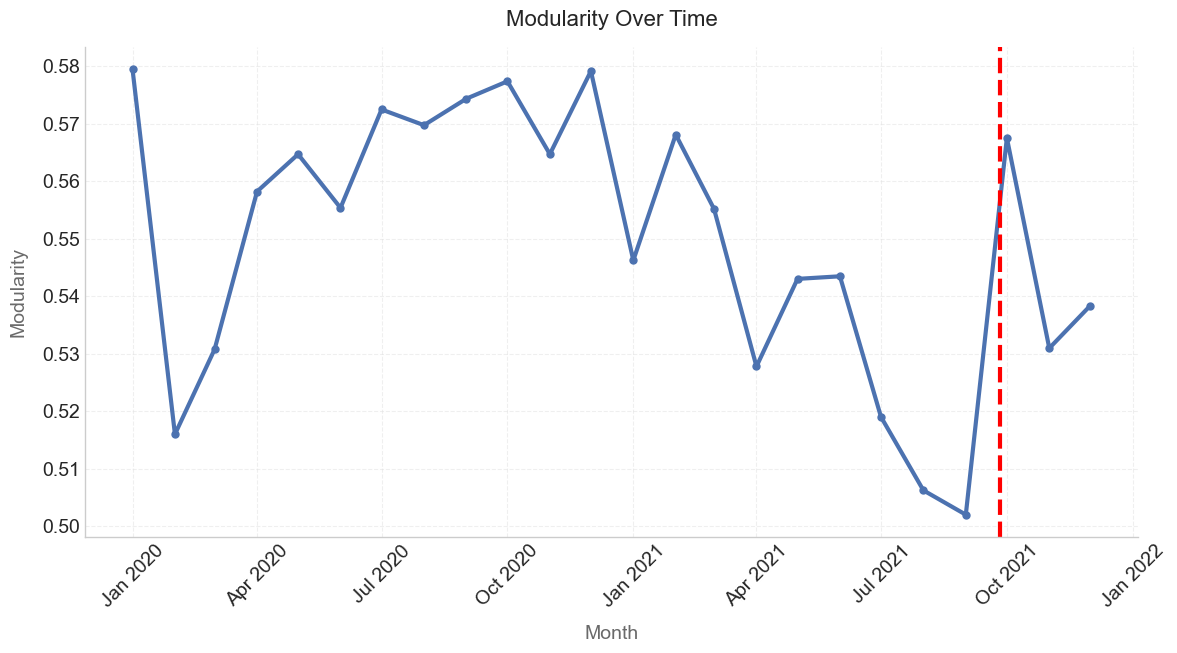

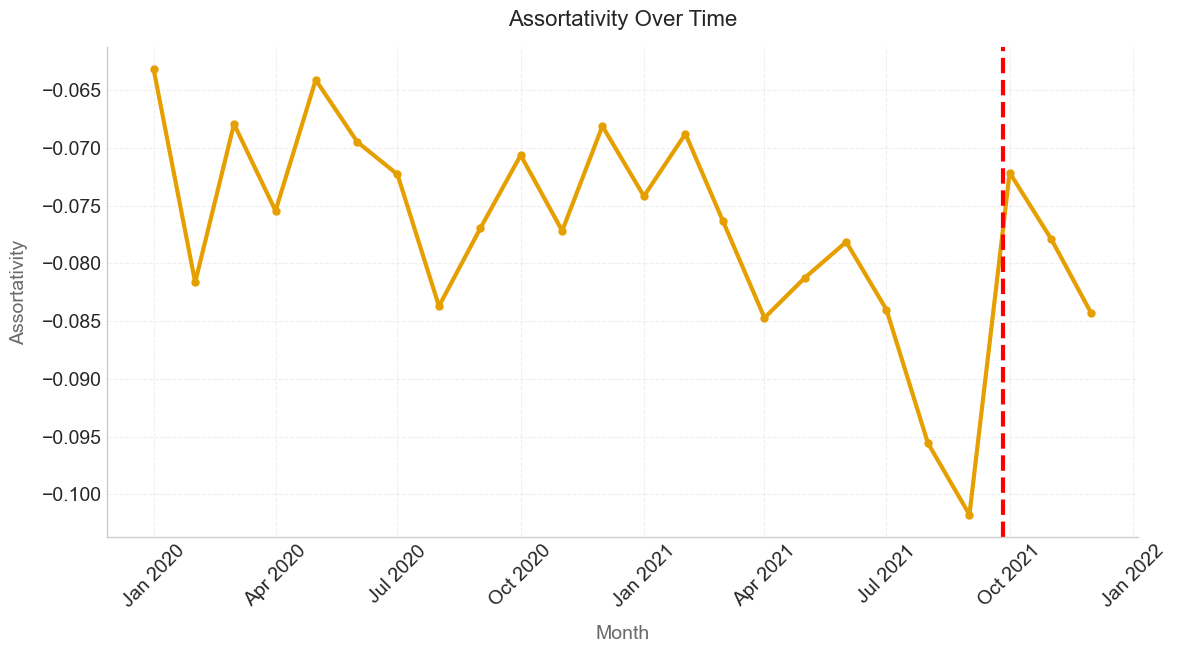

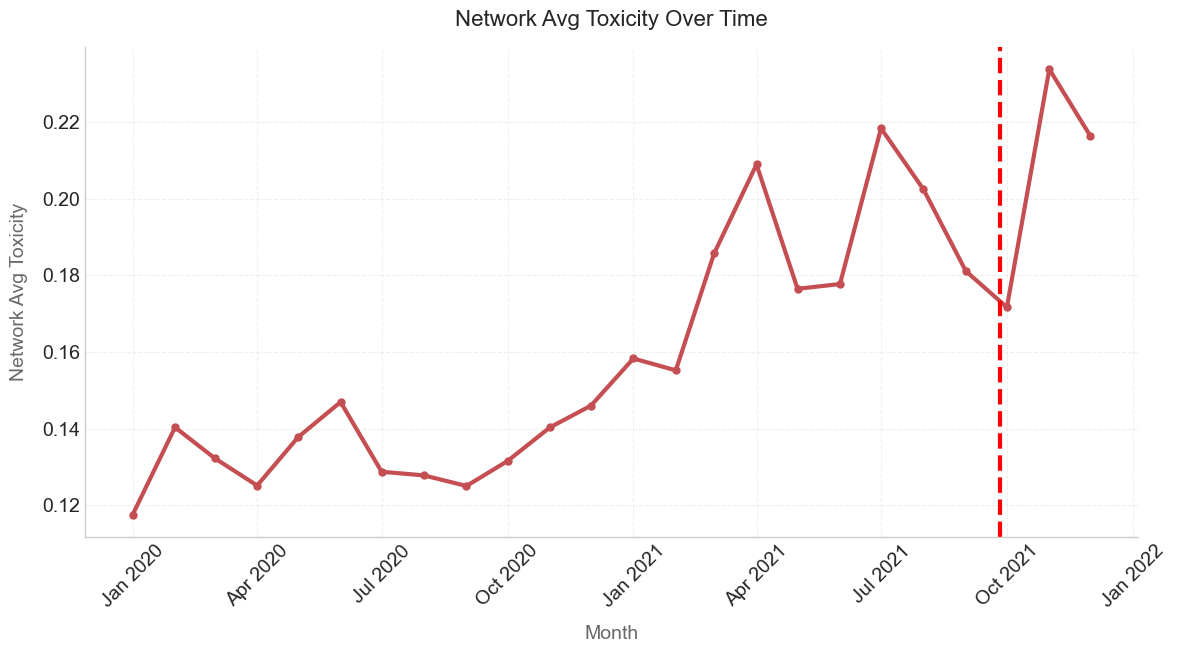

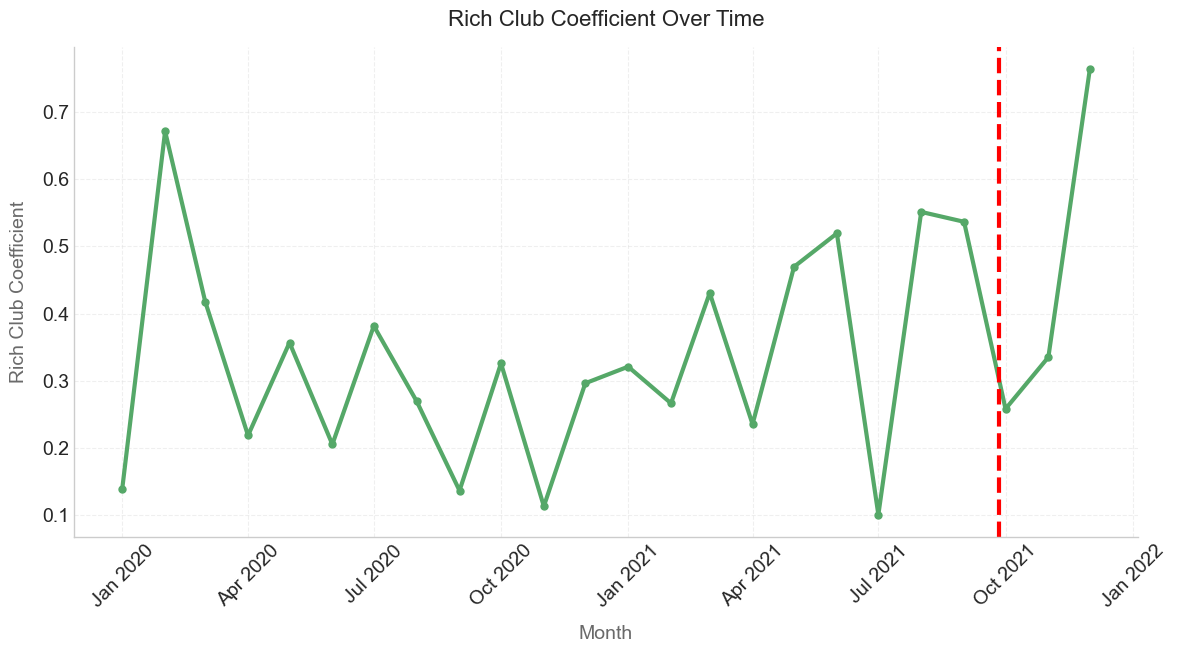

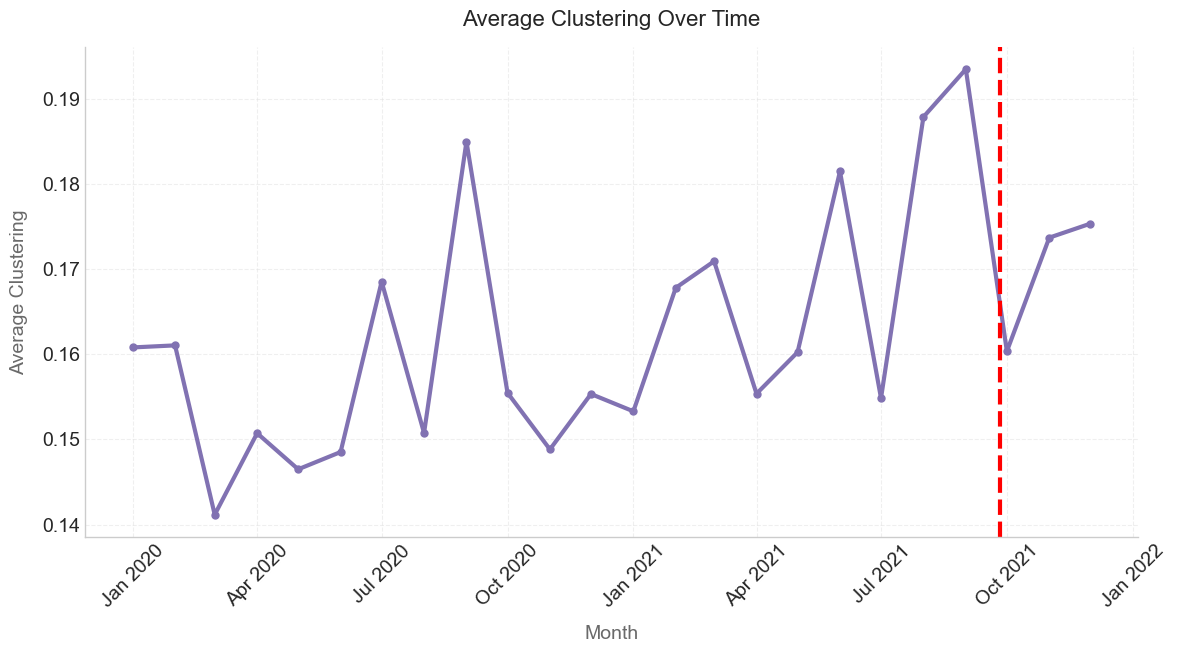

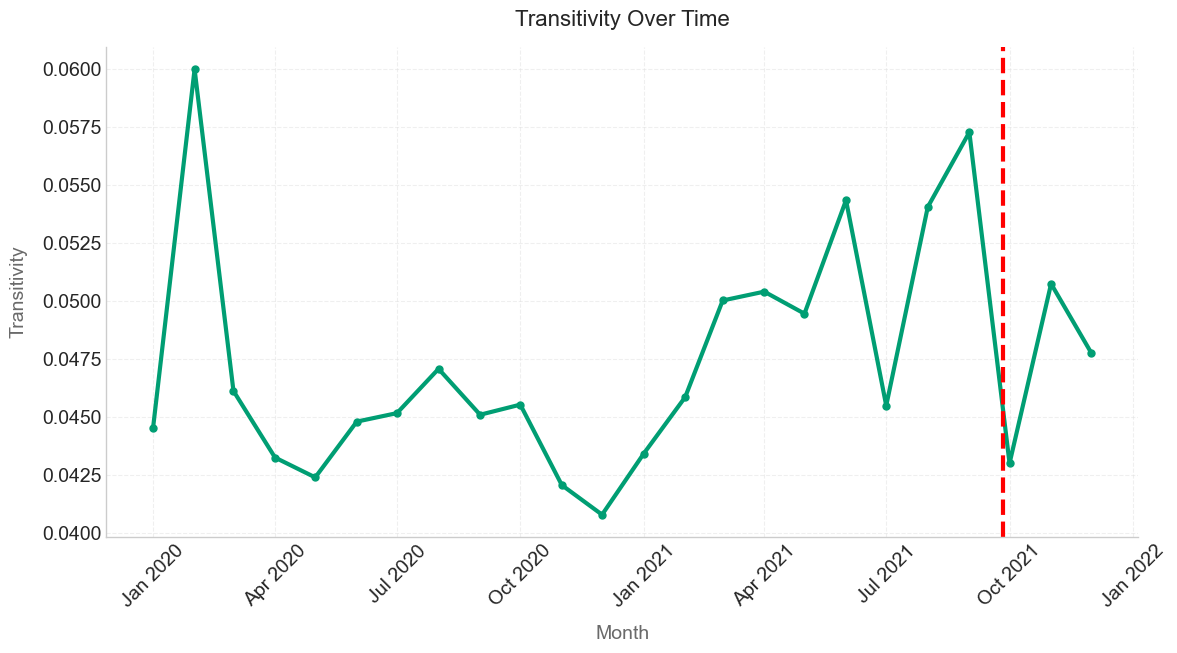

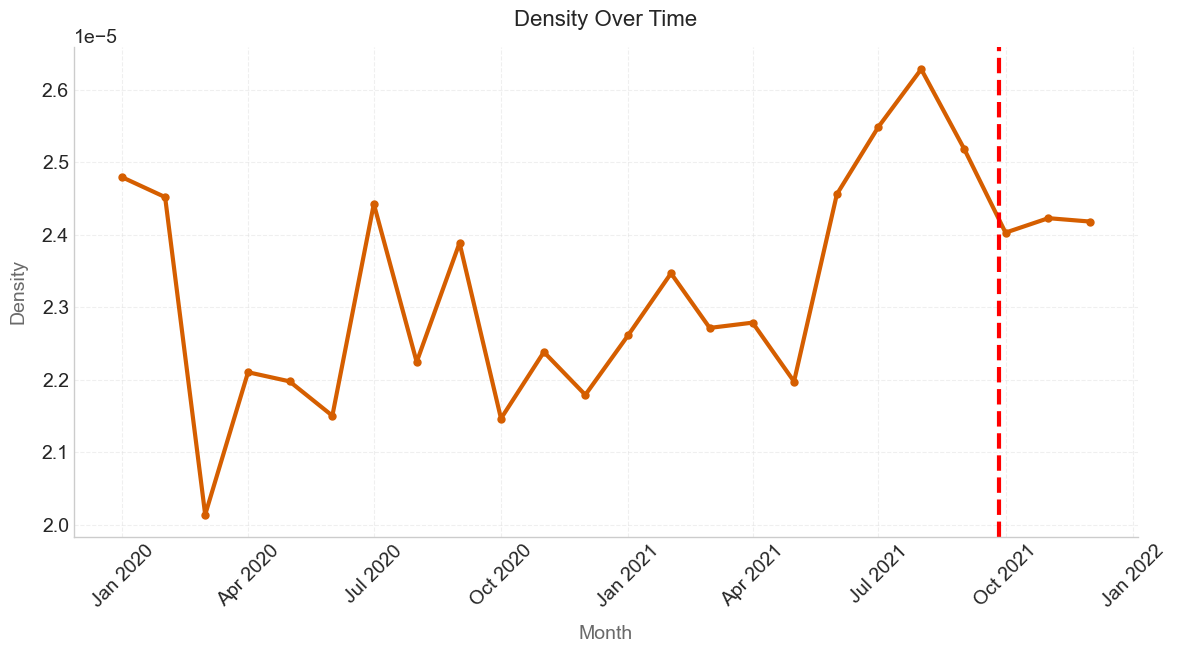

In [118]:
# Function to plot an individual metric over time
def plot_single_metric(df, metric, title, ylabel, color):
    """Plot a single network metric over time."""
    plt.figure(figsize=PLOT_FIGURE_SIZE)
    
    # Plot the metric
    plt.plot(df['month_start'], df[metric], 
             color=color, linewidth=LINE_WIDTH, 
             marker='o', markersize=MARKER_SIZE-5)
    
    # Add election line
    add_election_line(plt.gca())
    
    # Format x-axis with quarterly ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    
    # Format the plot
    format_plot(ax, 
                title=title,
                xlabel="Month",
                ylabel=ylabel)
    
    plt.tight_layout()
    plt.show()

# Plot each metric individually
for metric in metrics_of_interest:
    plot_single_metric(
        network_metrics_df, 
        metric, 
        f"{metric.replace('_', ' ').title()} Over Time",
        metric.replace('_', ' ').title(),
        METRIC_COLORS[metric]
    )

### 2.3 Normalized Metric Comparison

To compare the trends between modularity, toxicity, assortativity, and transitivity, let's create a normalized plot.

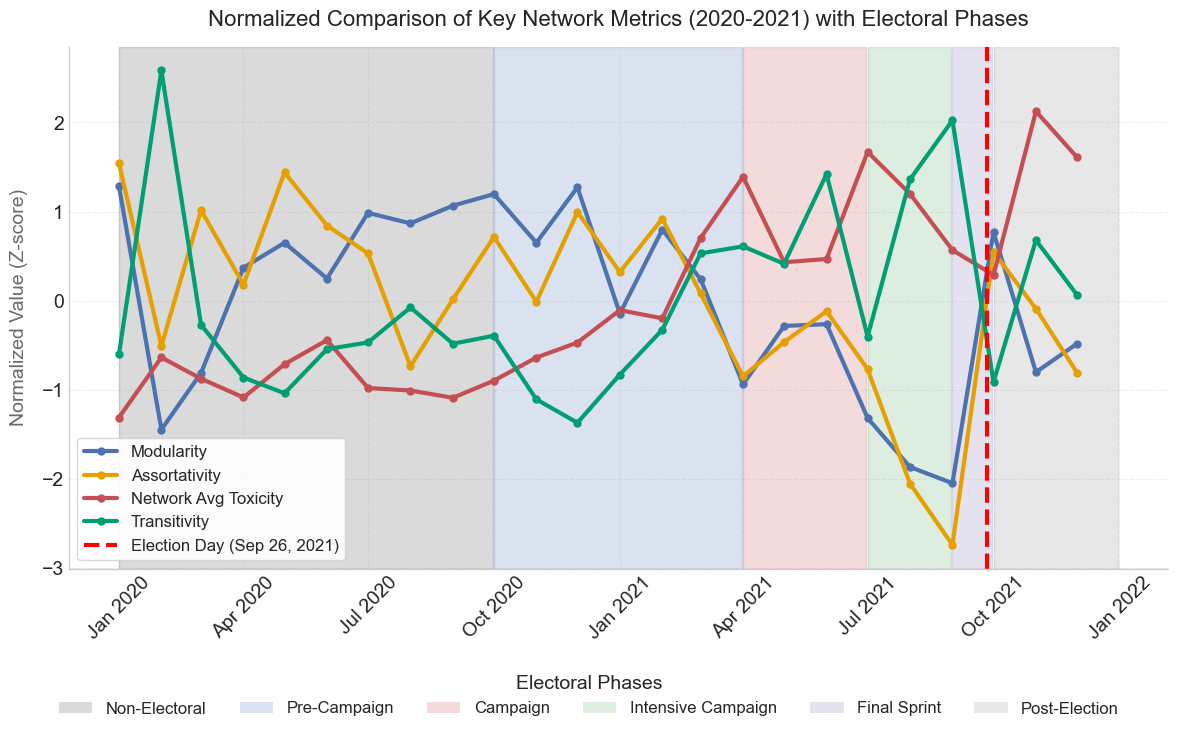

In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.patches import Patch


def plot_normalized_metrics_comparison(df, metrics, title):
    """Plot multiple normalized metrics for comparison with electoral phases."""
    # Create a copy of the dataframe
    plot_df = df.copy()

    fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

    # Define electoral phases with their date ranges
    electoral_phases = [{
        'name': 'Non-Electoral',
        'start': '2020-01-01',
        'end': '2020-09-30',
        'color': colors[0]
    }, {
        'name': 'Pre-Campaign',
        'start': '2020-10-01',
        'end': '2021-03-31',
        'color': colors[1]
    }, {
        'name': 'Campaign',
        'start': '2021-04-01',
        'end': '2021-06-30',
        'color': colors[2]
    }, {
        'name': 'Intensive Campaign',
        'start': '2021-07-01',
        'end': '2021-08-31',
        'color': colors[3]
    }, {
        'name': 'Final Sprint',
        'start': '2021-09-01',
        'end': '2021-09-30',
        'color': colors[4]
    }, {
        'name': 'Post-Election',
        'start': '2021-10-01',
        'end': '2021-12-31',
        'color': '#8B8B8B'
    }]

    # Highlight electoral phases with colored backgrounds
    phase_handles = []
    for phase in electoral_phases:
        start_date = pd.to_datetime(phase['start'])
        end_date = pd.to_datetime(phase['end'])
        ax.axvspan(start_date,
                   end_date,
                   alpha=0.2,
                   color=phase['color'],
                   zorder=1)
        phase_handles.append(
            Patch(facecolor=phase['color'], alpha=0.2, label=phase['name']))

    # Normalize and plot each metric
    for metric in metrics:
        values = plot_df[metric].values
        norm_values = (values - values.mean()) / values.std()
        ax.plot(plot_df['month_start'],
                norm_values,
                label=metric.replace('_', ' ').title(),
                color=METRIC_COLORS[metric],
                linewidth=LINE_WIDTH,
                marker='o',
                markersize=MARKER_SIZE - 5)

    # Add election line
    add_election_line(ax, label=True)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Format the plot
    format_plot(ax,
                title=title,
                xlabel="",
                ylabel="Normalized Value (Z-score)",
                legend_loc='best')

    # Create only the electoral phase legend below the plot
    fig.subplots_adjust(bottom=0.25)  # Add space for the legend
    phase_legend = fig.legend(handles=phase_handles,
                              loc='lower center',
                              bbox_to_anchor=(0.5, -0.1),
                              title="Electoral Phases",
                              ncol=len(electoral_phases),
                              frameon=False)

    plt.tight_layout()
    file_name = 'normalized_metrics_comparison.png'
    plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
    plt.show()

# Plot normalized comparison of key metrics with electoral phases
comparison_metrics = ['modularity', 'assortativity', 'network_avg_toxicity', 'transitivity']
plot_normalized_metrics_comparison(
    network_metrics_df,
    comparison_metrics,
    'Normalized Comparison of Key Network Metrics (2020-2021) with Electoral Phases'
)




## 3. Node-Level Metrics Analysis

Now we'll analyze node-level metrics to understand the role of influential accounts in the network.

In [120]:
LIMIT_TOP_NODES = 10000

# Get top nodes by pagerank for the election month (September 2021)
node_query = f"""
SELECT 
    nm.node_id,
    nm.pagerank,
    nm.degree_in,
    nm.degree_out,
    nm.betweenness,
    nm.clustering,
    nm.core_number,
    nm.interactions_sent,
    nm.interactions_received,
    nm.interactions_total,
    nm.toxicity_sent_avg,
    nm.toxicity_received_avg,
    account.party,
    account.account_type,
    account.confidence
FROM 
    `grounded-nebula-408412.twitter_analysis_00_source_python.node_metrics_all` nm
JOIN 
    `grounded-nebula-408412.base_twitter_python.account_types` account
ON 
    nm.node_id = account.node_id
WHERE 
    nm.month_start = '2021-09-01'
ORDER BY 
    nm.pagerank DESC
LIMIT  {LIMIT_TOP_NODES};
"""

# Execute the query
top_nodes_df = run_query(node_query, use_cache=QUERY_USE_CACHE)

# Check if data is available
if top_nodes_df.empty:
    print("No data returned from the node metrics query.")
else:
    # Filter out 'AccountTypeEnum.OTHER'
    top_nodes_df = top_nodes_df[top_nodes_df['account_type'] != 'AccountTypeEnum.OTHER'].reset_index(drop=True)
    
    # Display the first few rows
    top_nodes_df.head(20)

Query executed successfully. Retrieved 10000 rows.
Columns: ['node_id', 'pagerank', 'degree_in', 'degree_out', 'betweenness', 'clustering', 'core_number', 'interactions_sent', 'interactions_received', 'interactions_total', 'toxicity_sent_avg', 'toxicity_received_avg', 'party', 'account_type', 'confidence']


### 3.1 Analysis of Top Influential Accounts by PageRank

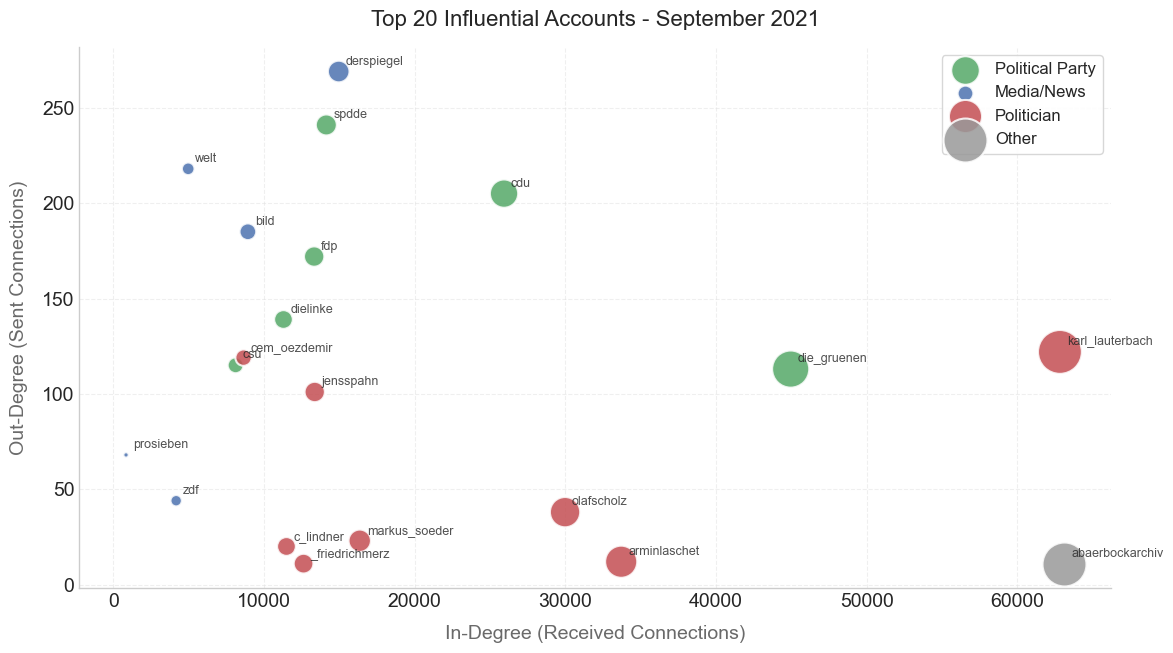

In [121]:
# Create a bubble chart of the top nodes by pagerank
def plot_top_nodes_bubble(df, metric_x, metric_y, metric_size, 
                         x_label, y_label, size_label, title,
                         top_n=20, file_name=None):
    """
    Create a bubble chart showing the top nodes by pagerank,
    with bubble size representing another metric.
    """
    # Get top N nodes
    top_df = df.head(top_n)
    
    # Create a scatter plot with bubbles
    plt.figure(figsize=PLOT_FIGURE_SIZE)
    
    # Plot each account type
    for account_type in set(top_df['account_type']):
        nodes = top_df[top_df['account_type'] == account_type]
        if not nodes.empty:
            plt.scatter(
                nodes[metric_x], 
                nodes[metric_y], 
                s=nodes[metric_size]/df[metric_size].max() * 1000,
                alpha=0.85,  # Increased alpha value
                edgecolors='w', 
                linewidth=1.5,
                c=[ACCOUNT_TYPE_COLORS.get(account_type, colors[0])],
                label=account_type
            )
    
    # Add labels for each node
    for i, row in top_df.iterrows():
        plt.annotate(
            row['node_id'], 
            (row[metric_x], row[metric_y]),
            xytext=(5, 5), 
            textcoords='offset points',
            fontsize=9, 
            alpha=0.8
        )
    
    # Format the plot
    ax = plt.gca()
    format_plot(
        ax, 
        title=title,
        xlabel=x_label,
        ylabel=y_label,
        ylim_start=0,  # Ensure y-axis starts at 0
        legend_loc='upper right'
    )
    
    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name), dpi=PLOT_DPI, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Create bubble chart of top nodes by pagerank, degree, and interactions
plot_top_nodes_bubble(
    top_nodes_df, 
    'degree_in', 
    'degree_out', 
    'interactions_total',
    'In-Degree (Received Connections)', 
    'Out-Degree (Sent Connections)', 
    'Total Interactions', 
    'Top 20 Influential Accounts - September 2021'
)

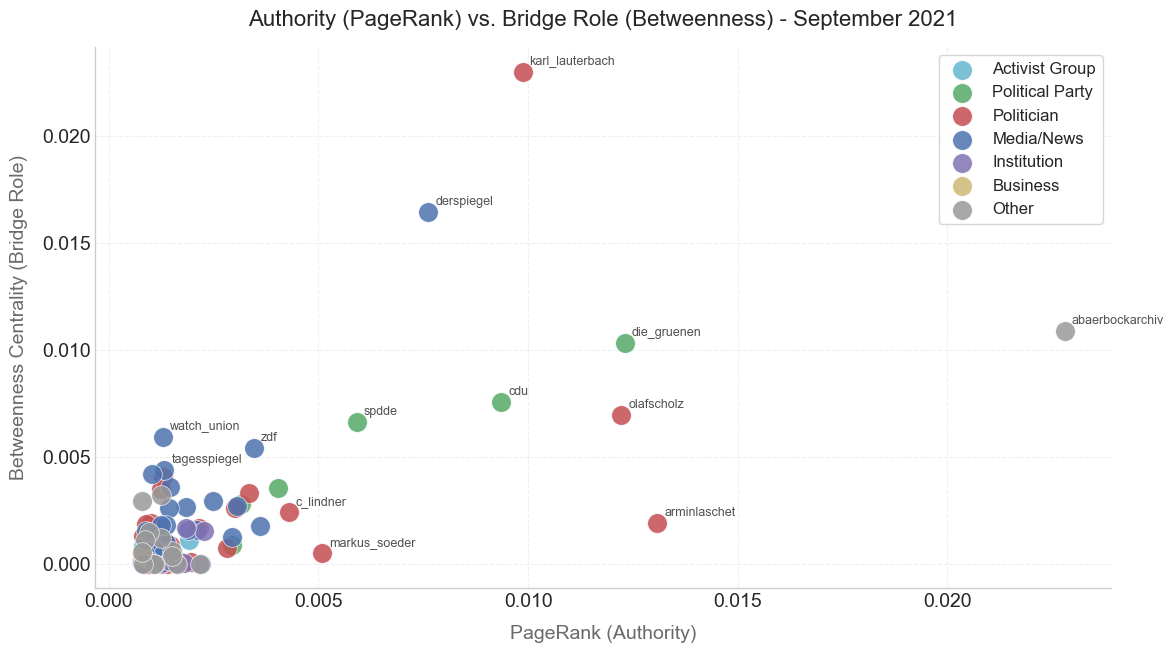

No political party nodes found in the top node data.


In [122]:
# Create a scatter plot comparing pagerank and betweenness
def plot_centrality_comparison(df, title, top_n=100, file_name=None):
    """
    Create a scatter plot showing the relationship between PageRank and Betweenness
    colored by account type.
    """
    # Check if the dataframe is empty
    if df.empty:
        print("No data available for centrality comparison plot.")
        return
        
    # Get top N nodes
    plot_df = df.head(top_n).copy()
    
    # Create figure
    plt.figure(figsize=PLOT_FIGURE_SIZE)
    
    # Plot each account type
    for account_type in set(plot_df['account_type']):
        nodes = plot_df[plot_df['account_type'] == account_type]
        if not nodes.empty:
            plt.scatter(
                nodes['pagerank'], 
                nodes['betweenness'], 
                s=200, 
                alpha=0.85,  # Increased alpha value
                edgecolors='w', 
                linewidth=0.5,
                c=[ACCOUNT_TYPE_COLORS.get(account_type, colors[0])],
                label=account_type
            )
    
    # Add labels for notable nodes
    for i, row in plot_df.iterrows():
        if (row['pagerank'] > plot_df['pagerank'].quantile(0.9) or 
            row['betweenness'] > plot_df['betweenness'].quantile(0.9)):
            plt.annotate(
                row['node_id'], 
                (row['pagerank'], row['betweenness']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, 
                alpha=0.8
            )
    
    # Format the plot
    ax = plt.gca()
    format_plot(
        ax, 
        title=title,
        xlabel="PageRank (Authority)",
        ylabel="Betweenness Centrality (Bridge Role)",
        ylim_start=0,  # Ensure y-axis starts at 0
        legend_loc='upper right'
    )
    
    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name), dpi=PLOT_DPI, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Extract political party nodes - Do this AFTER top_nodes_df is created
if 'top_nodes_df' in locals() and not top_nodes_df.empty:
    # Create scatter plot comparing PageRank and Betweenness
    plot_centrality_comparison(
        top_nodes_df,
        'Authority (PageRank) vs. Bridge Role (Betweenness) - September 2021'
    )
    
    # Extract political party nodes with explicit check for enum values
    party_nodes_df = top_nodes_df[top_nodes_df['account_type'] == str(AccountTypeEnum.POLITICAL_PARTY)].copy()
    
    # Check if we have party nodes to analyze
    if not party_nodes_df.empty:
        # Compare political party metrics
        party_metrics = ['pagerank', 'toxicity_sent_avg', 'toxicity_received_avg', 'betweenness']
        
        # Create a metric comparison table for political parties
        party_comparison = party_nodes_df[['node_id', 'pagerank', 'degree_in', 'degree_out', 
                                          'betweenness', 'core_number', 
                                          'toxicity_sent_avg', 'toxicity_received_avg']].copy()
        
        # Add party names
        party_comparison['party_name'] = party_comparison['node_id'].map(PARTY_NAMES)
        
        # Sort by pagerank
        party_comparison = party_comparison.sort_values('pagerank', ascending=False)
        
        # Display the comparison table
        print("Political Party Metrics Comparison - September 2021")
        display(party_comparison)
    else:
        print("No political party nodes found in the top node data.")

### 3.2 Analysis of Toxicity vs. Centrality

Let's examine the relationship between centrality measures and toxicity in the network.

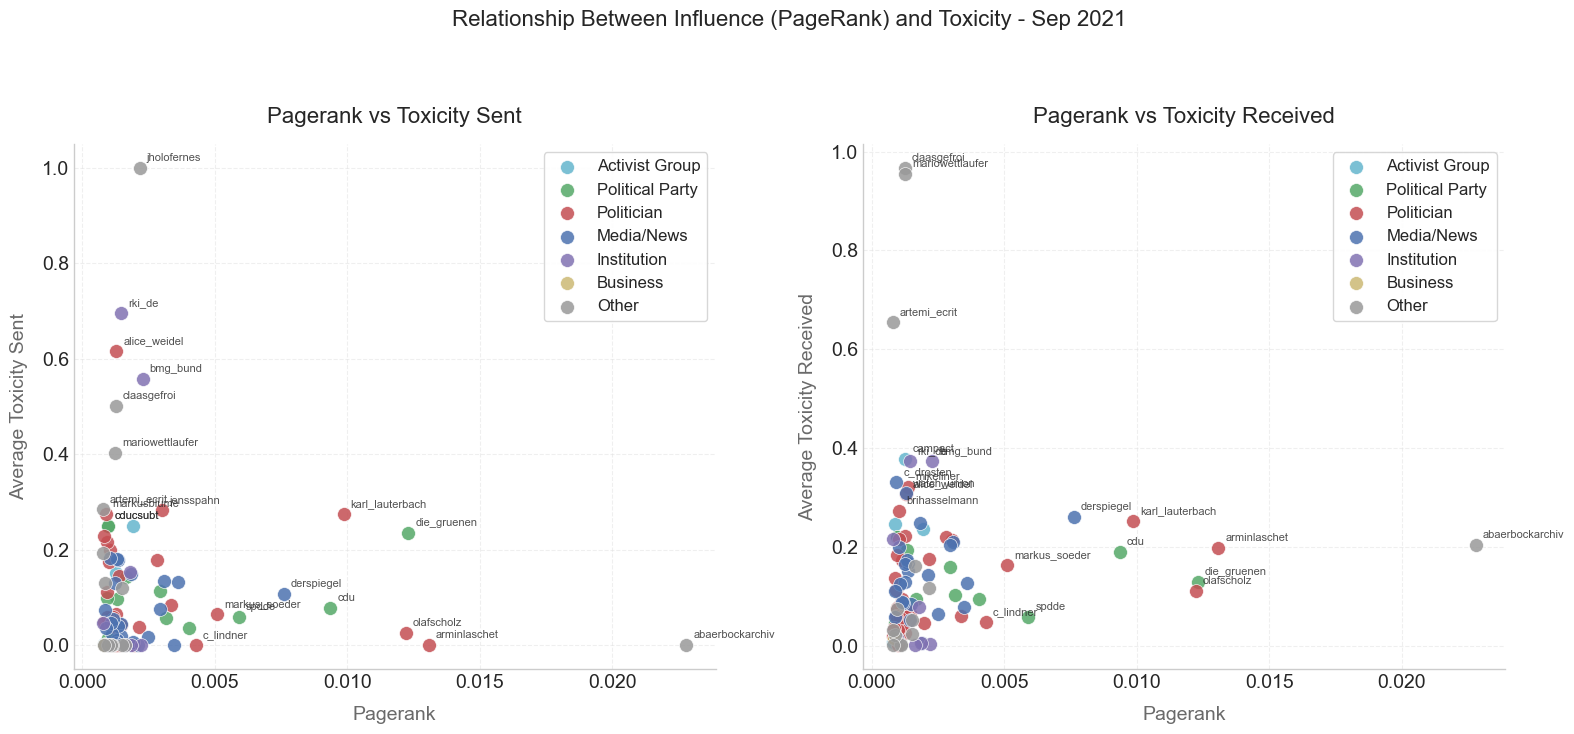

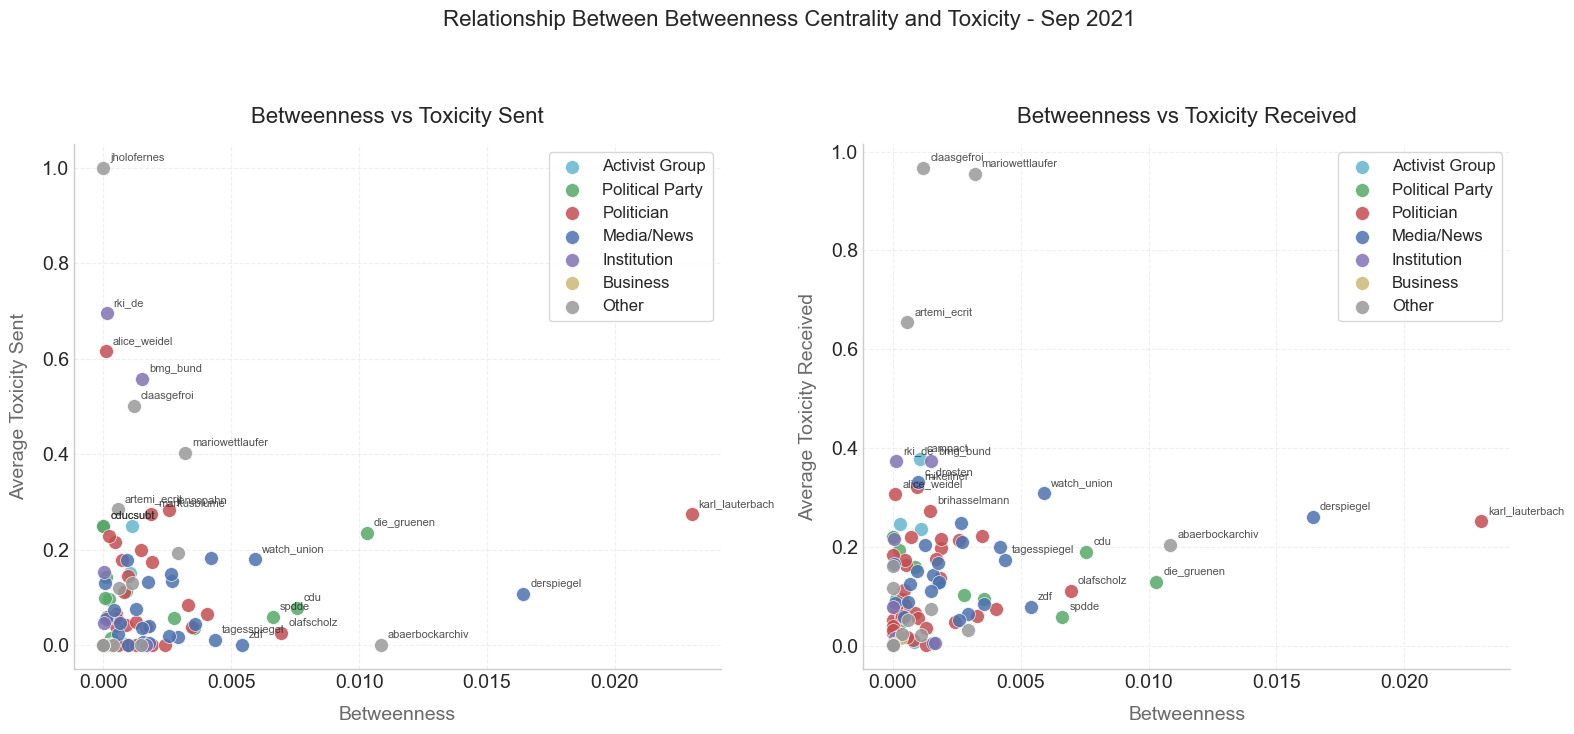

In [123]:
# Create a scatter plot of centrality vs toxicity
def plot_centrality_toxicity(df, metric, title, top_n=100):
    """
    Create a scatter plot showing the relationship between a centrality metric
    and toxicity sent/received.
    """
    # Get top N nodes
    plot_df = df.head(top_n).copy()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # First subplot: Centrality vs Toxicity Sent
    for account_type in set(plot_df['account_type']):
        nodes = plot_df[plot_df['account_type'] == account_type]
        if not nodes.empty:
            ax1.scatter(
                nodes[metric], 
                nodes['toxicity_sent_avg'], 
                s=100, 
                alpha=0.85,  # Increased alpha value
                edgecolors='w', 
                linewidth=0.5,
                c=[ACCOUNT_TYPE_COLORS.get(account_type, colors[0])],
                label=account_type
            )
    
    # Add labels for notable nodes in first subplot
    for i, row in plot_df.iterrows():
        if row['toxicity_sent_avg'] > 0.25 or row[metric] > plot_df[metric].quantile(0.9):
            ax1.annotate(
                row['node_id'], 
                (row[metric], row['toxicity_sent_avg']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8, 
                alpha=0.8
            )
    
    # Format first subplot
    format_plot(
        ax1, 
        title=f"{metric.replace('_', ' ').title()} vs Toxicity Sent",
        xlabel=metric.replace('_', ' ').title(),
        ylabel="Average Toxicity Sent",
        legend_loc='upper right'
    )
    
    # Second subplot: Centrality vs Toxicity Received
    for account_type in set(plot_df['account_type']):
        nodes = plot_df[plot_df['account_type'] == account_type]
        if not nodes.empty:
            ax2.scatter(
                nodes[metric], 
                nodes['toxicity_received_avg'], 
                s=100, 
                alpha=0.85,  # Increased alpha value
                edgecolors='w', 
                linewidth=0.5,
                c=[ACCOUNT_TYPE_COLORS.get(account_type, colors[0])],
                label=account_type
            )
    
    # Add labels for notable nodes in second subplot
    for i, row in plot_df.iterrows():
        if row['toxicity_received_avg'] > 0.25 or row[metric] > plot_df[metric].quantile(0.9):
            ax2.annotate(
                row['node_id'], 
                (row[metric], row['toxicity_received_avg']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8, 
                alpha=0.8
            )
    
    # Format second subplot
    format_plot(
        ax2, 
        title=f"{metric.replace('_', ' ').title()} vs Toxicity Received",
        xlabel=metric.replace('_', ' ').title(),
        ylabel="Average Toxicity Received",
        legend_loc='upper right'
    )
    
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Create scatter plots for different centrality metrics vs toxicity
plot_centrality_toxicity(
    top_nodes_df, 
    'pagerank', 
    'Relationship Between Influence (PageRank) and Toxicity - Sep 2021'
)

plot_centrality_toxicity(
    top_nodes_df, 
    'betweenness',
    'Relationship Between Betweenness Centrality and Toxicity - Sep 2021'
)

### 3.3 Political Party Node Analysis

Let's analyze the network position and toxicity metrics for official political party and politician accounts.

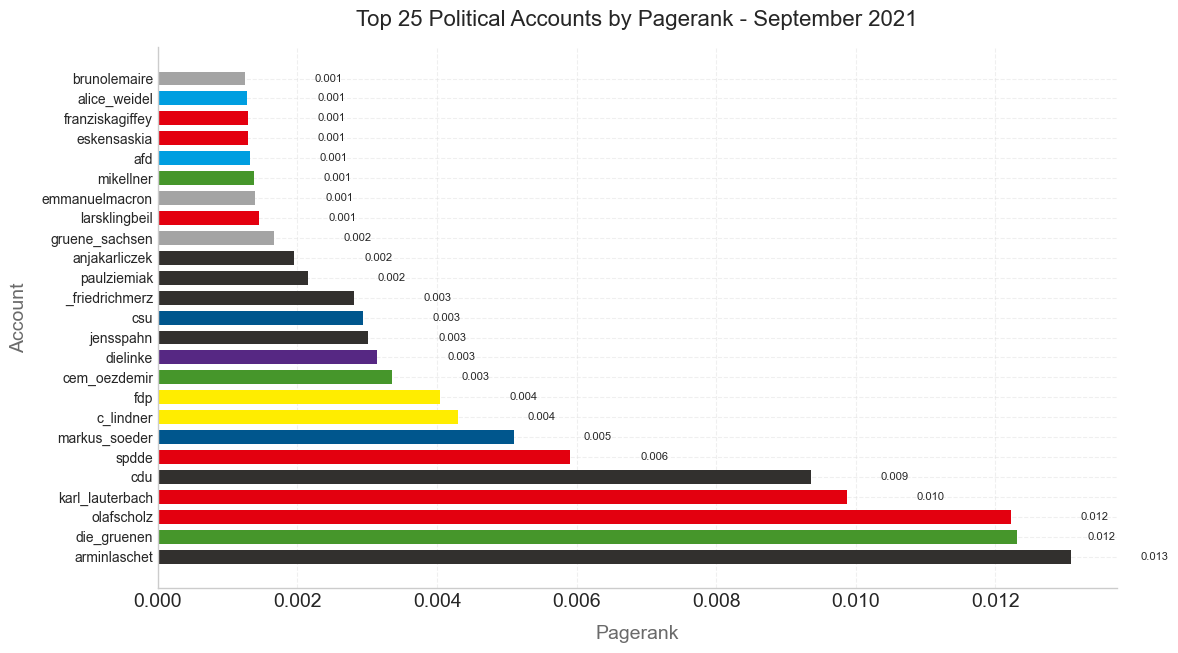

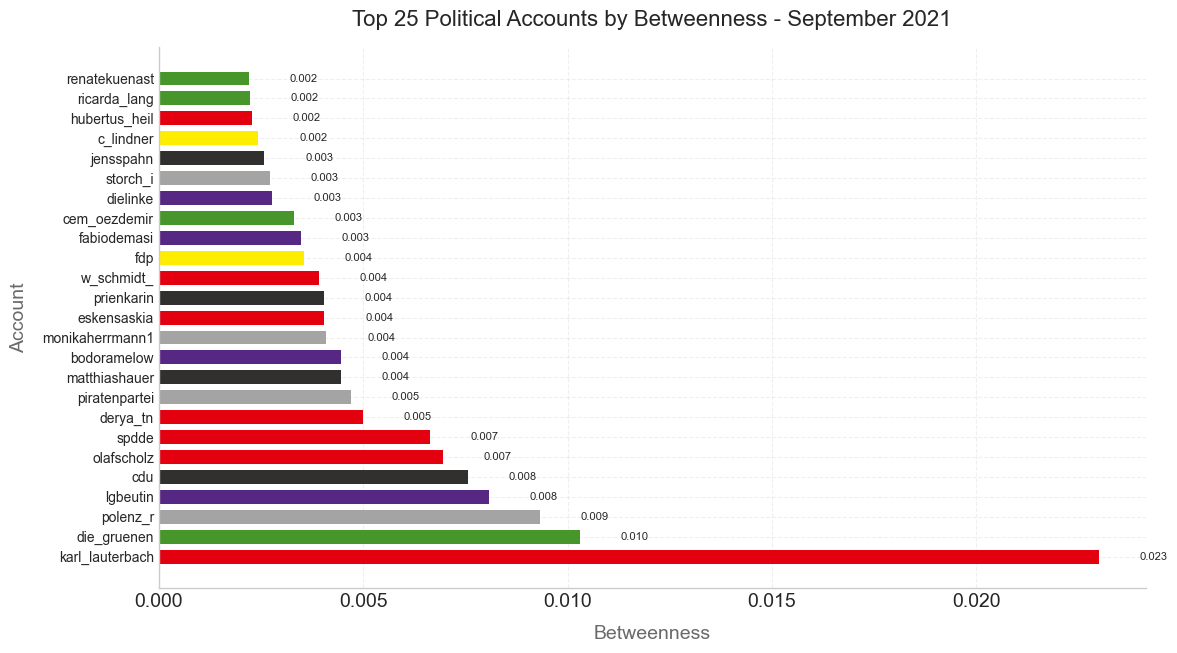

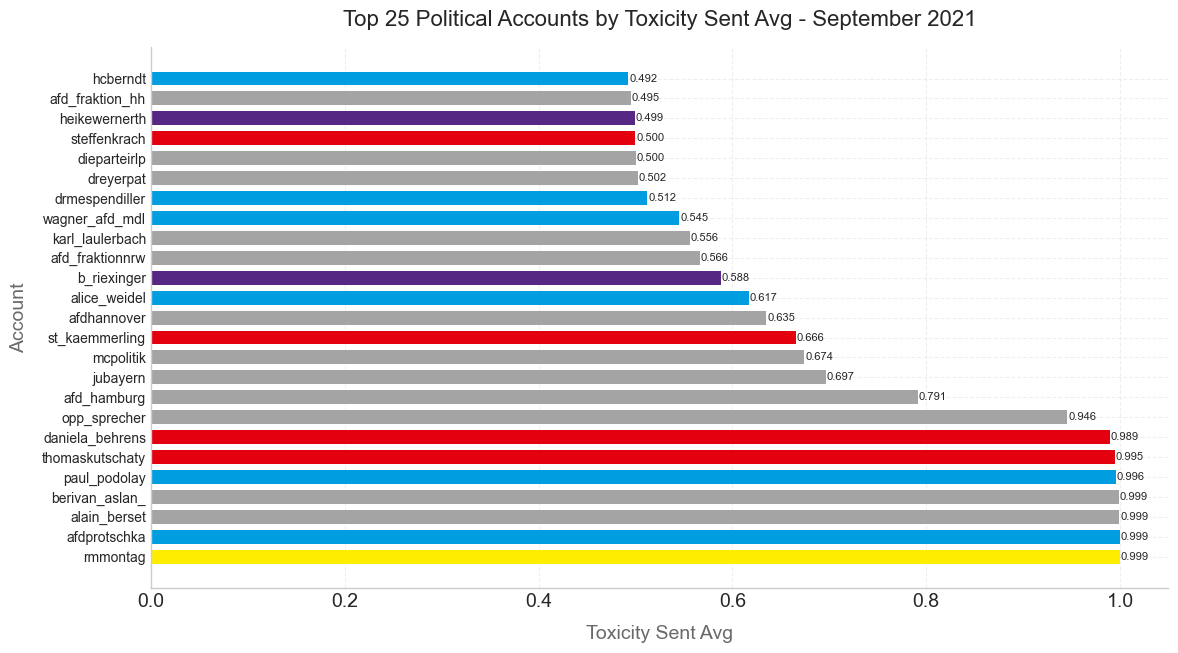

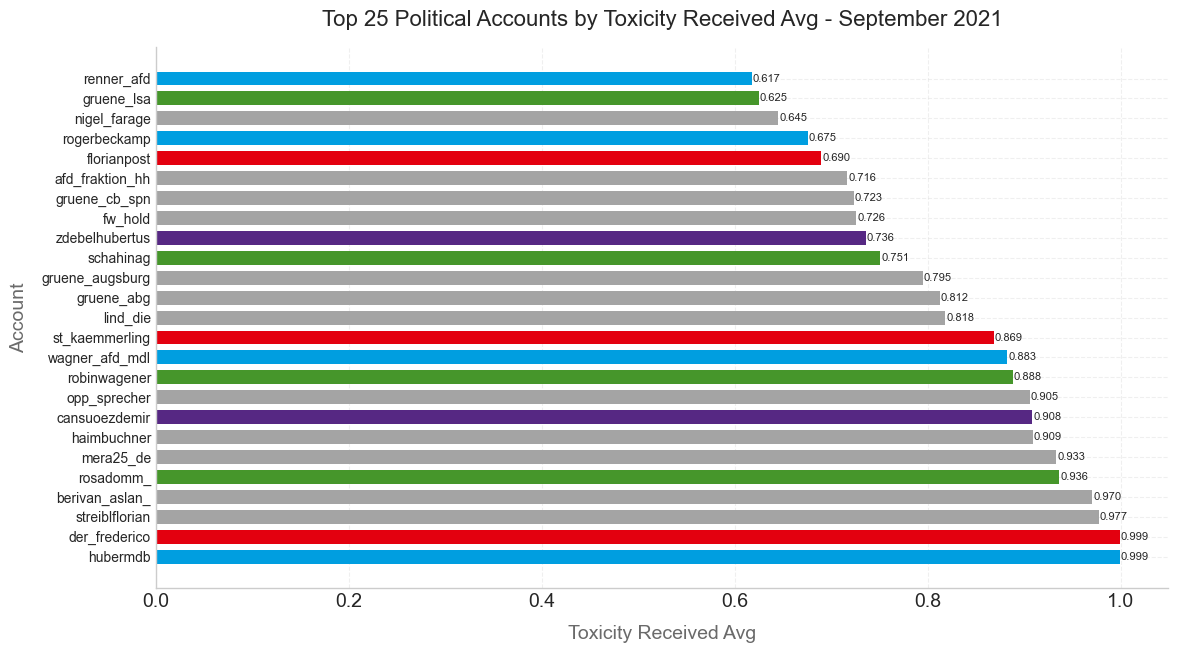

In [124]:
# Get top politician and political party nodes
political_nodes_df = top_nodes_df[
    (top_nodes_df['account_type'] == AccountTypeEnum.POLITICAL_PARTY) |
    (top_nodes_df['account_type'] == AccountTypeEnum.POLITICIAN)
].copy()

# Check if we have political nodes
if political_nodes_df.empty:
    print("No political party or politician nodes found in the top node data.")
else:
    # Create function for horizontal bar charts of metrics
    def plot_top_political_metrics(df,
                                   metric,
                                   title,
                                   top_n=25,
                                   file_name=None):
        """
        Create a horizontal bar chart showing the top accounts for a specific metric.
        """
        # Create a copy and sort by the metric
        plot_df = df.copy().sort_values(metric, ascending=False).head(top_n)

        # Create figure
        plt.figure(figsize=PLOT_FIGURE_SIZE)

        # Define colors based on node_id and account type
        # Define colors based on party affiliation
        colors = []
        for _, row in plot_df.iterrows():
            node_id = row['node_id']
            party = row['party']

            # print("node_id:", node_id)
            # print("party:", party)
            # print("COLOR_PARTY:", COLOR_PARTY)
            # print(f"""COLOR_PARTY[{party}]:""", COLOR_PARTY.get(party))
            # Ensure party name is not None and normalize it for comparison
            if pd.notna(party):
                normalized_party = party.strip().lower(
                )  # Remove spaces and make lowercase

                # Try direct match
                if party in COLOR_PARTY:
                    colors.append(COLOR_PARTY[party])
                # Try case-insensitive matching
                elif normalized_party in [
                        k.lower() for k in COLOR_PARTY.keys()
                ]:
                    matched_party_key = next(
                        (k for k in COLOR_PARTY.keys()
                         if k.lower() == normalized_party), None)
                    colors.append(COLOR_PARTY[matched_party_key])
                # Try partial matching (handling names with extra words like "Bündnis 90/Die Grünen")
                else:
                    matched_party_key = next(
                        (k for k in COLOR_PARTY.keys()
                         if normalized_party in k.lower()), None)
                    if matched_party_key:
                        colors.append(COLOR_PARTY[matched_party_key])
                    else:
                        colors.append(
                            '#A4A4A4')  # Default gray for unknown parties
            else:
                colors.append('#A4A4A4')  # Default color for missing party

        # Create horizontal bar chart
        bars = plt.barh(y=plot_df['node_id'],
                        width=plot_df[metric],
                        height=0.7,
                        color=colors)

        # Add value labels
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width if width > 0 else 0
            plt.text(label_x_pos + 0.001,
                     bar.get_y() + bar.get_height() / 2,
                     f'{width:.3f}',
                     va='center',
                     fontsize=8)

        # Format plot
        ax = plt.gca()
        format_plot(
            ax,
            title=title,
            xlabel=metric.replace('_', ' ').title(),
            ylabel="Account",
            # ylim_start=None  # Not needed for horizontal bars
        )

        # Adjust y-axis labels to be more visible
        plt.tick_params(axis='y', which='major', labelsize=10)

        # Add tight layout
        plt.tight_layout()

        # Save if file_name is provided
        if file_name:
            plt.savefig(os.path.join(OUTPUT_DIR, file_name),
                        dpi=PLOT_DPI,
                        bbox_inches='tight')

        plt.show()
        plt.close()

    # Plot top accounts for each metric
    metrics_to_plot = [
        'pagerank', 'betweenness', 'toxicity_sent_avg', 'toxicity_received_avg'
    ]

    for metric in metrics_to_plot:
        plot_top_political_metrics(
            political_nodes_df,
            metric,
            f'Top 25 Political Accounts by {metric.replace("_", " ").title()} - September 2021',
            file_name=f'political_top25_{metric}.png')

In [125]:
# Create a metric comparison table for political parties
if 'party_nodes_df' in locals() and not party_nodes_df.empty:
    party_comparison = party_nodes_df[['node_id', 'pagerank', 'degree_in', 'degree_out', 
                                      'betweenness', 'core_number', 
                                      'toxicity_sent_avg', 'toxicity_received_avg']].copy()

    # Add party names
    party_comparison['party_name'] = party_comparison['node_id'].map(PARTY_NAMES)

    # Sort by pagerank
    party_comparison = party_comparison.sort_values('pagerank', ascending=False)

    # Display the comparison table
    print("Political Party Metrics Comparison - September 2021")
    display(party_comparison)

### 3.4 Analysis of Toxicity Distribution Among Different Account Types

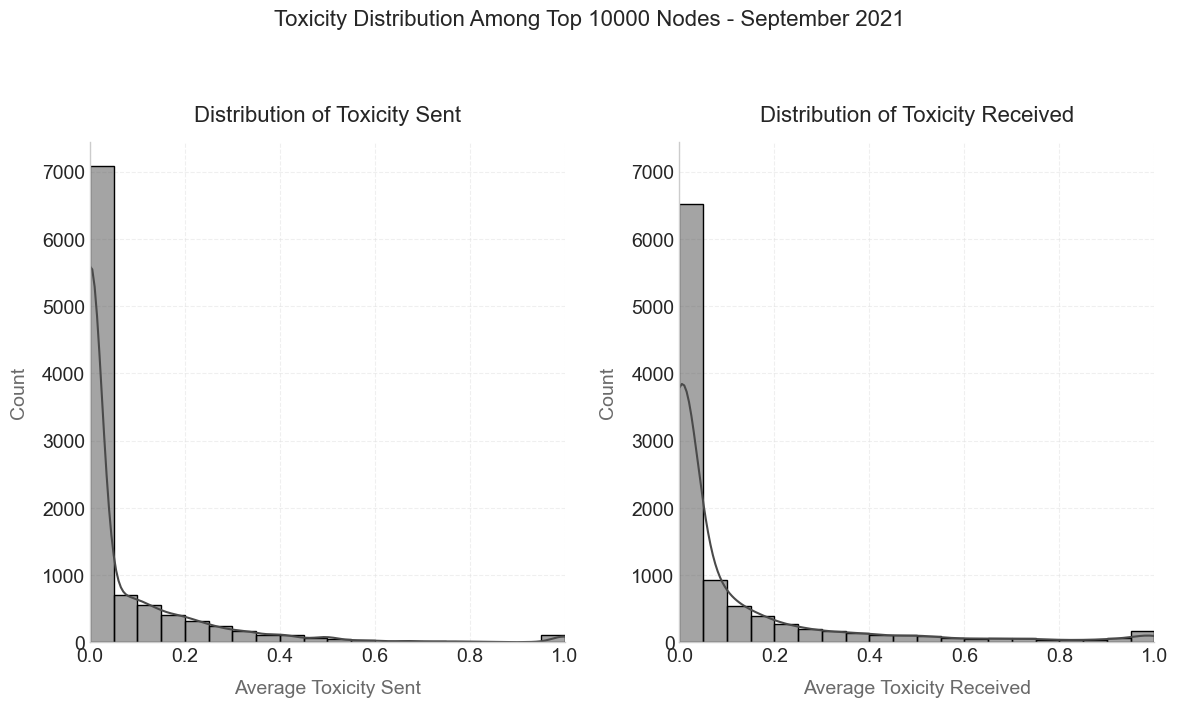

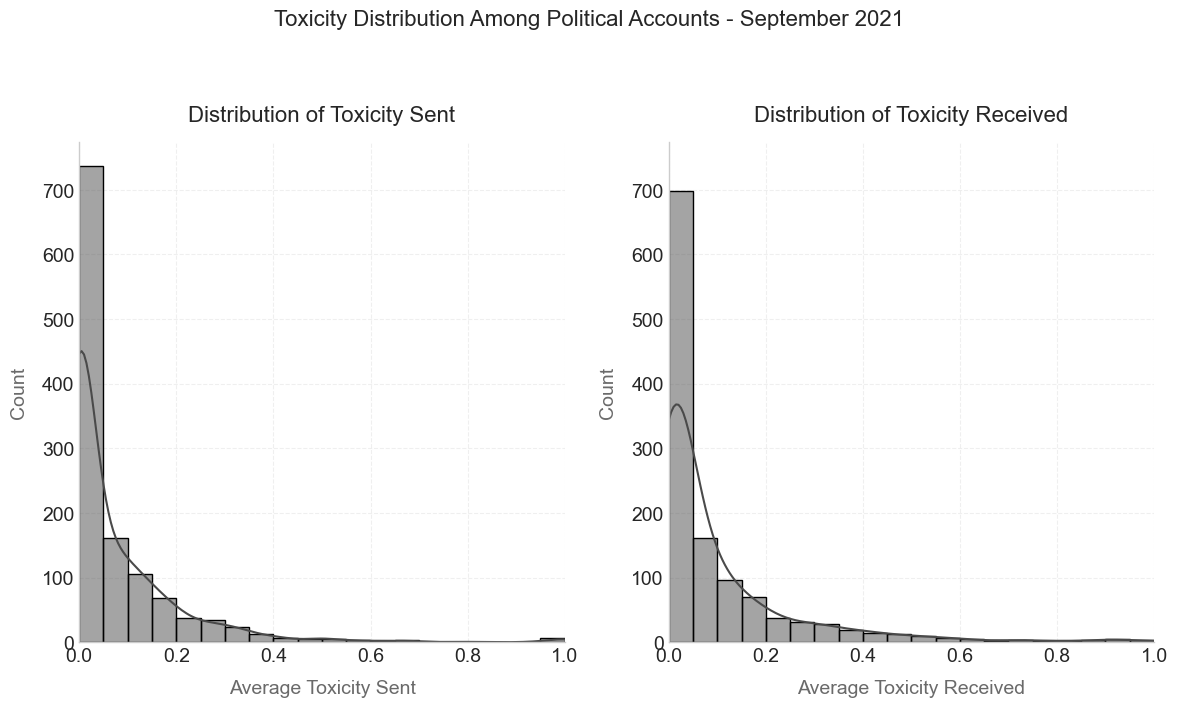

In [126]:
# Create a histogram of toxicity distribution with shared y-axis limits
TOP_NODES_LIMIT = 10000

def plot_toxicity_distribution(df,
                               title,
                               account_filter=None,
                               bins=20,
                               top_n=TOP_NODES_LIMIT,
                               file_name=None):

    # Check if the dataframe is empty
    if df.empty:
        print("No data available for toxicity distribution plot.")
        return

    # Apply filter if provided
    if account_filter:
        plot_df = df[df.apply(account_filter, axis=1)].head(top_n).copy()
        if plot_df.empty:
            print("No data available after applying filter.")
            return
    else:
        plot_df = df.head(top_n).copy()

    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=PLOT_FIGURE_SIZE)

    # Plot toxicity sent distribution
    sns.histplot(plot_df['toxicity_sent_avg'], bins=bins, kde=True, ax=ax1)
    format_plot(ax1,
                title='Distribution of Toxicity Sent',
                xlabel='Average Toxicity Sent',
                ylabel='Count')

    # Plot toxicity received distribution
    sns.histplot(plot_df['toxicity_received_avg'], bins=bins, kde=True, ax=ax2)
    format_plot(ax2,
                title='Distribution of Toxicity Received',
                xlabel='Average Toxicity Received',
                ylabel='Count')

    # Determine the max y-limit across both plots
    max_y = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

    # Set the same y-limit for both plots
    ax1.set_ylim(0, max_y)
    ax2.set_ylim(0, max_y)
    ax1.set_xlim(0, 1)
    ax2.set_xlim(0, 1)

    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()

    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name),
                    dpi=PLOT_DPI,
                    bbox_inches='tight')

    plt.show()
    plt.close()

# Plot toxicity distribution for all accounts
if 'top_nodes_df' in locals() and not top_nodes_df.empty:
    # All top accounts
    plot_toxicity_distribution(
        top_nodes_df,
        f'Toxicity Distribution Among Top {TOP_NODES_LIMIT} Nodes - September 2021',
        file_name='toxicity_distribution_all.png'
    )

    # Only political accounts
    plot_toxicity_distribution(
        top_nodes_df,
        'Toxicity Distribution Among Political Accounts - September 2021',
        account_filter=lambda row: (row['account_type'] == AccountTypeEnum.POLITICIAN) |
                                   (row['account_type'] == AccountTypeEnum.POLITICAL_PARTY),
        file_name='toxicity_distribution_political.png'
    )

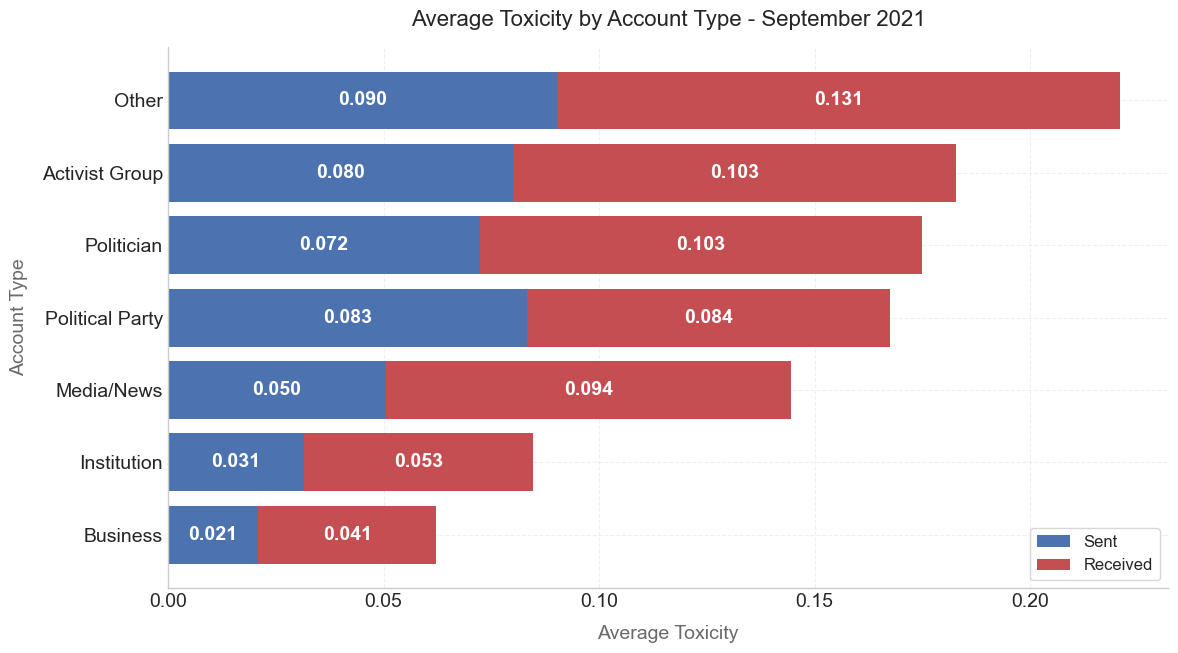

In [127]:
# Create a horizontal bar chart of toxicity by account type
def plot_toxicity_by_account_type(df, title, file_name=None):
    """
    Create horizontal bar charts showing average toxicity by account type,
    sorted by total toxicity.
    """
    # Check if the dataframe is empty
    if df.empty:
        print("No data available for toxicity by account type plot.")
        return

    # Calculate mean toxicity by account type
    toxicity_by_type = df.groupby('account_type')[['toxicity_sent_avg', 'toxicity_received_avg']].mean().reset_index()
    
    # Add total toxicity column for sorting
    toxicity_by_type['total_toxicity'] = toxicity_by_type['toxicity_sent_avg'] + toxicity_by_type['toxicity_received_avg']
    
    # Sort by total toxicity
    toxicity_by_type = toxicity_by_type.sort_values('total_toxicity', ascending=True)

    # Create figure
    plt.figure(figsize=PLOT_FIGURE_SIZE)

    # Plot data
    y = toxicity_by_type['account_type']
    sent = toxicity_by_type['toxicity_sent_avg']
    received = toxicity_by_type['toxicity_received_avg']

    # Create horizontal stacked bars
    plt.barh(y, sent, color='#4C72B0', label='Sent')
    plt.barh(y, received, left=sent, color='#C44E52', label='Received')

    # Format plot
    ax = plt.gca()
    format_plot(ax,
                title=title,
                xlabel="Average Toxicity",
                ylabel="Account Type",
                # ylim_start=None,  # Not needed for horizontal bars
                legend_loc='lower right')

    # Add value labels
    for i, (s, r) in enumerate(zip(sent, received)):
        # Label for sent
        plt.text(s/2, i, f'{s:.3f}', ha='center', va='center', color='white', fontweight='bold')
        # Label for received
        plt.text(s + r/2, i, f'{r:.3f}', ha='center', va='center', color='white', fontweight='bold')

    plt.tight_layout()

    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name), dpi=PLOT_DPI, bbox_inches='tight')

    plt.show()
    plt.close()

# Plot toxicity by account type
if 'top_nodes_df' in locals() and not top_nodes_df.empty:
    plot_toxicity_by_account_type(
        top_nodes_df,
        'Average Toxicity by Account Type - September 2021',
        file_name='toxicity_by_account_type.png')

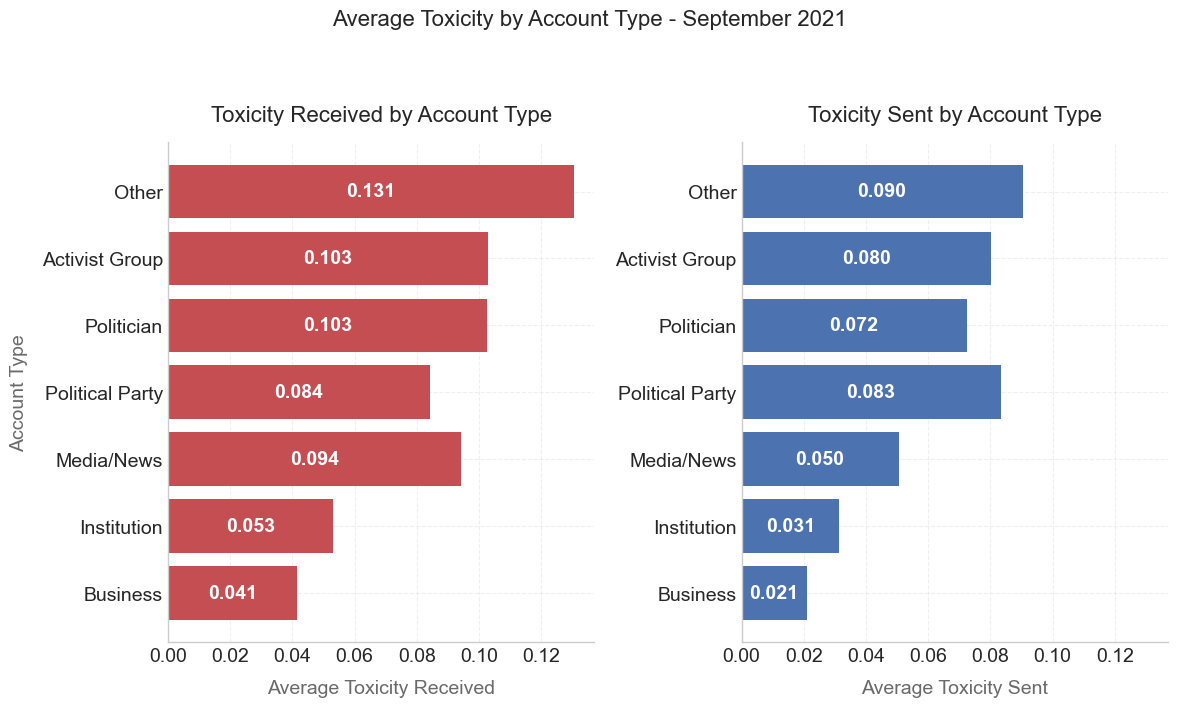

In [128]:
# Create side-by-side horizontal bar charts for toxicity by account type
def plot_toxicity_by_account_type_side_by_side(df, title, file_name=None):
    """
    Create side-by-side horizontal bar charts showing average toxicity received and sent
    by account type, sorted by total toxicity.
    """
    # Check if the dataframe is empty
    if df.empty:
        print("No data available for toxicity by account type plot.")
        return

    # Calculate mean toxicity by account type
    toxicity_by_type = df.groupby('account_type')[['toxicity_sent_avg', 'toxicity_received_avg']].mean().reset_index()
    
    # Add total toxicity column for sorting
    toxicity_by_type['total_toxicity'] = toxicity_by_type['toxicity_sent_avg'] + toxicity_by_type['toxicity_received_avg']
    
    # Sort by total toxicity
    toxicity_by_type = toxicity_by_type.sort_values('total_toxicity', ascending=True)

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=PLOT_FIGURE_SIZE)
    
    # Plot data
    y = toxicity_by_type['account_type']
    sent = toxicity_by_type['toxicity_sent_avg']
    received = toxicity_by_type['toxicity_received_avg']

    # Left plot: Received toxicity
    ax1.barh(y, received, color='#C44E52')
    format_plot(ax1,
                title='Toxicity Received by Account Type',
                xlabel='Average Toxicity Received',
                ylabel='Account Type')
                
    # Add value labels to received plot
    for i, r in enumerate(received):
        ax1.text(r/2, i, f'{r:.3f}', ha='center', va='center', color='white', fontweight='bold')
    
    # Right plot: Sent toxicity
    ax2.barh(y, sent, color='#4C72B0')
    format_plot(ax2,
                title='Toxicity Sent by Account Type',
                xlabel='Average Toxicity Sent',
                ylabel='')  # No need for duplicate y-label
                
    # Add value labels to sent plot
    for i, s in enumerate(sent):
        ax2.text(s/2, i, f'{s:.3f}', ha='center', va='center', color='white', fontweight='bold')
    
    # Determine the max x-limit for both plots
    max_x = max(sent.max(), received.max()) * 1.05  # Add 5% margin
    
    # Set the same x-limit for both plots
    ax1.set_xlim(0, max_x)
    ax2.set_xlim(0, max_x)

    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()

    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name),
                    dpi=PLOT_DPI,
                    bbox_inches='tight')

    plt.show()
    plt.close()

# Plot toxicity by account type
if 'top_nodes_df' in locals() and not top_nodes_df.empty:
    plot_toxicity_by_account_type_side_by_side(
        top_nodes_df,
        'Average Toxicity by Account Type - September 2021',
        file_name='toxicity_by_account_type_side_by_side.png')

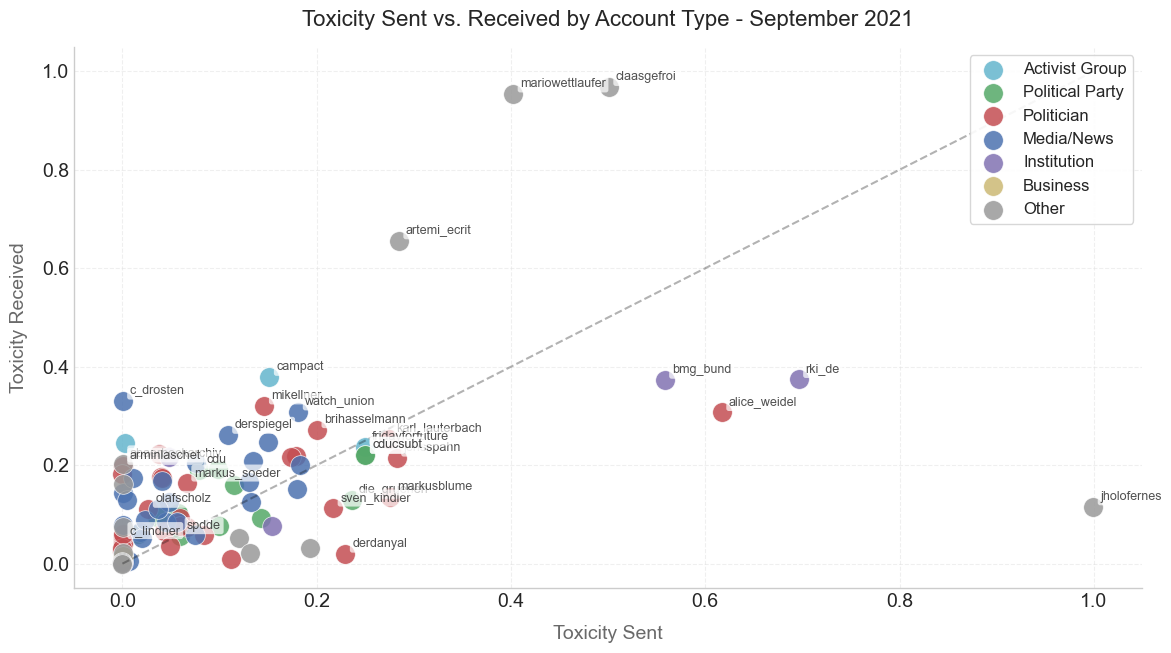

In [129]:
# Create a scatter plot of toxicity sent vs. received colored by account type
def plot_toxicity_relationship(df, title, top_n=100, file_name=None):
    """
    Create a scatter plot showing the relationship between toxicity sent and received,
    colored by account type.
    """
    # Check if the dataframe is empty
    if df.empty:
        print("No data available for toxicity relationship plot.")
        return
        
    # Get top N nodes
    plot_df = df.head(top_n).copy()
    
    # Create figure (square for scatter plots)
    plt.figure(figsize=PLOT_FIGURE_SIZE)
    
    # Plot each account type
    for account_type in set(plot_df['account_type']):
        nodes = plot_df[plot_df['account_type'] == account_type]
        if not nodes.empty:
            plt.scatter(
                nodes['toxicity_sent_avg'], 
                nodes['toxicity_received_avg'], 
                s=200, 
                alpha=0.85,
                edgecolors='w', 
                linewidth=0.5,
                c=[ACCOUNT_TYPE_COLORS.get(account_type, colors[0])],
                label=account_type
            )
    
    # Add labels for notable nodes
    for i, row in plot_df.iterrows():
        if (row['toxicity_sent_avg'] > 0.2 or row['toxicity_received_avg'] > 0.3 or
            row['pagerank'] > plot_df['pagerank'].quantile(0.9)):
            
            # Create a background for the text to improve readability
            text = plt.annotate(
                row['node_id'], 
                (row['toxicity_sent_avg'], row['toxicity_received_avg']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, 
                alpha=0.8,
                backgroundcolor='white',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
            )
    
    # Add diagonal line for equal toxicity
    max_val = max(plot_df['toxicity_sent_avg'].max(), plot_df['toxicity_received_avg'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    
    # Format the plot
    ax = plt.gca()
    format_plot(
        ax, 
        title=title,
        xlabel="Toxicity Sent",
        ylabel="Toxicity Received",
        legend_loc='upper right'
    )
    
    # Save if file_name is provided
    if file_name:
        plt.savefig(os.path.join(OUTPUT_DIR, file_name), dpi=PLOT_DPI, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot toxicity sent vs. received
if 'top_nodes_df' in locals() and not top_nodes_df.empty:
    plot_toxicity_relationship(
        top_nodes_df,
        'Toxicity Sent vs. Received by Account Type - September 2021',
        file_name='toxicity_relationship.png'
    )

## 4. Summary of Key Findings

Based on the analysis of network structure during the 2021 German Federal Election,  following key findings can be highlighted:

1. **Network Modularity and Fragmentation**:
   - Modularity scores show a distinct pattern over time, with notable increases preceding the election period.
   - This suggests increasing discourse fragmentation as the election approached.

2. **Toxicity and Network Structure**:
   - Network toxicity shows correlation with structural metrics like modularity and assortativity.
   - Periods of heightened toxicity coincide with increased network fragmentation.

3. **Political Party Positioning**:
   - The CDU and Die Grünen show the highest pagerank scores, indicating central positions in the discourse network.
   - The AfD exhibits a distinctive pattern of high toxicity sent and received, suggesting a polarizing role.

4. **Influential Nodes**:
   - Political candidates (e.g., Armin Laschet, Olaf Scholz) have high centrality but varying toxicity profiles.
   - Media accounts occupy bridging positions (high betweenness) between community clusters.

5. **Core-Periphery Structure**:
   - The network shows a clear core-periphery structure with influence concentrated among a small set of accounts.
   - Different account types play distinct structural roles in the network.

